<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a probar todas las parejas posibles de métodos de fairness que afecten a distintas partes del proceso de la construcción del algoritmo de machine learning usando dos variables sensibles. Vamos a hacer un estudio de simulación.

# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

#Simulacion
from aif360.datasets import BinaryLabelDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:
def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x)/(1+np.exp(x))

def simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma):
    
    p = n_var + n_sens
    coef = np.concatenate((gamma, beta))
        
    X = np.random.multivariate_normal(mean_vec, cov, size = n_obs)
    probs_var = inv_logit(X)
    bin = np.random.binomial(1, probs_var)
    
    probs_Y = inv_logit(coef.dot(X.T))
    Y = np.random.binomial(1, probs_Y)
    
    names = ['0' for i in range(p+1)]
    sens = ['0' for i in range(n_sens)]
    var = 1
    
    names[0] = 'response'
    
    for i in range(1,p+1):
        if i-1 < n_sens:
            sens[i-1] = 'sens ' + str(i)
            names[i] = 'sens ' + str(i)
        if i-1 >= n_sens:
            names[i] = 'var ' + str(var)
            var += 1
    
    names = np.array(names)
    sens = np.array(sens)
    response = np.array(['response'])
    
    Y = Y.reshape((n_obs,1))
    
    bin = np.concatenate((Y, bin), axis = 1)
    
    data_pd = pd.DataFrame(bin, columns = names)
    data = BinaryLabelDataset(df = data_pd, favorable_label = 1, unfavorable_label = 0, label_names = response, protected_attribute_names = sens)
    return data

In [4]:
n_obs = 1000
n_var = 30
n_sens = 2
mean_vec = np.zeros(n_var+n_sens)
cov = np.identity(n_var+n_sens)
beta = np.zeros(n_var)
gamma = np.ones(n_sens)

dataset1 = simulated_dataset(n_obs, n_var, n_sens, mean_vec, cov, beta, gamma)

#dataset.favorable_label = 1
#dataset.unfavorable_label = 0

new_data = dataset1.convert_to_dataframe()[0]

sens1 = new_data.loc[:,'sens 1']
sens2 = new_data.loc[:,'sens 2']
new_sens = sens1.copy()
new_sens[sens2 == 1] = 1

new_data = new_data.drop(['sens 1', 'sens 2'], axis = 1)
new_data['sens 1'] = new_sens

names = np.array(new_data.columns)
sens = np.array(['sens 1'])
response = np.array(['response'])

dataset = BinaryLabelDataset(df = new_data,
                             favorable_label = 1,
                             unfavorable_label = 0,
                             label_names = response,
                             protected_attribute_names = sens)

# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

data_train2, vt2 = dataset1.split([0.7], shuffle=True, seed=seed)
data_val2, data_test2 = vt2.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset.protected_attribute_names[0]
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset)
    
print(f'Dimensiones del conjunto de datos: {dataset.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset.favorable_label)
print("Label del grupo desfavorable:", dataset.unfavorable_label)

Dimensiones del conjunto de datos: (1000, 31)
Grupos privilegiados: [{'sens 1': 1.0}]
Grupos no privilegiados: [{'sens 1': 0.0}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 12 ms, sys: 7 µs, total: 12 ms
Wall time: 11.2 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4141
AUC: 0.5367
Balanced accuracy: 0.5650
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.2082
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1498
Sufficiency ( |ΔPPV| ) : 0.2462
CPU times: user 170 ms, sys: 10.7 ms, total: 181 ms
Wall time: 163 ms


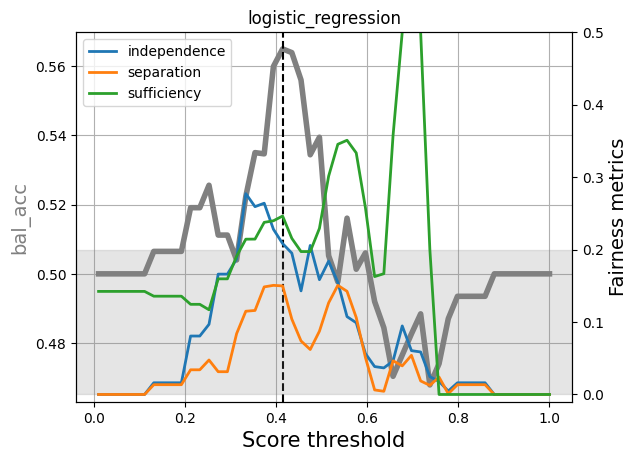

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.4141
AUC: 0.5376
Balanced accuracy: 0.5267
Accuracy: 0.5267
Independence ( |ΔP(Y_pred = 1)| ): 0.2025
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0279
Sufficiency ( |ΔPPV| ) : 0.1100


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 33.4 s, sys: 276 ms, total: 33.7 s
Wall time: 591 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.0466
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0301
Sufficiency ( |ΔPPV| ) : 0.1261
CPU times: user 2.3 s, sys: 0 ns, total: 2.3 s
Wall time: 161 ms


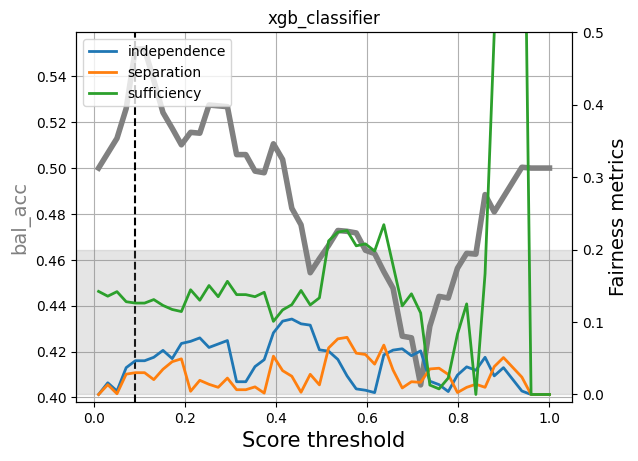

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4868
Balanced accuracy: 0.5000
Accuracy: 0.5000
Independence ( |ΔP(Y_pred = 1)| ): 0.0548
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0053
Sufficiency ( |ΔPPV| ) : 0.0962


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_REW = PreProcessor.transform(data_train_copy)
data_val_REW = PreProcessor.transform(data_val_copy)
data_test_REW = PreProcessor.transform(data_test_copy)

CPU times: user 12.8 ms, sys: 130 µs, total: 12.9 ms
Wall time: 11.8 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

### Eliminador de impacto dispar

In [13]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_DIR = PreProcessor.fit_transform(data_train_copy)
data_val_DIR = PreProcessor.fit_transform(data_val_copy)
data_test_DIR = PreProcessor.fit_transform(data_test_copy)



CPU times: user 149 ms, sys: 20.1 ms, total: 169 ms
Wall time: 168 ms


## Entrenamiento de técnicas de inprocesado

Entrenamos ahora los algoritmos de inprocesado para aplicarlos posteriormente cuando hagan falta.

### Eliminador de prejuicios por regularización

In [14]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [15]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [16]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )
    models[model_name_quality].scores_train = models[model_name_quality].predict(data_train_copy).scores
    models[model_name_quality].scores_val = models[model_name_quality].predict(data_val_copy).scores
    models[model_name_quality].scores_test = models[model_name_quality].predict(data_test_copy).scores

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [17]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Eliminación de prejuicios adversarios

In [18]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

2024-06-19 10:14:46.106079: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-19 10:14:46.354616: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.749668; batch adversarial loss: 0.640720
epoch 1; iter: 0; batch classifier loss: 0.720532; batch adversarial loss: 0.619733
epoch 2; iter: 0; batch classifier loss: 0.682275; batch adversarial loss: 0.631128
epoch 3; iter: 0; batch classifier loss: 0.736333; batch adversarial loss: 0.622782
epoch 4; iter: 0; batch classifier loss: 0.686564; batch adversarial loss: 0.628857
epoch 5; iter: 0; batch classifier loss: 0.705573; batch adversarial loss: 0.633000
epoch 6; iter: 0; batch classifier loss: 0.698191; batch adversarial loss: 0.632932
epoch 7; iter: 0; batch classifier loss: 0.666563; batch adversarial loss: 0.654302
epoch 8; iter: 0; batch classifier loss: 0.703034; batch adversarial loss: 0.662812
epoch 9; iter: 0; batch classifier loss: 0.708887; batch adversarial loss: 0.669348
epoch 10; iter: 0; batch classifier loss: 0.669129; batch adversarial loss: 0.652118
epoch 11; iter: 0; batch classifier loss: 0.668132; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4215
Balanced accuracy: 0.5195
Accuracy: 0.5067
Independence ( |ΔP(Y_pred = 1)| ): 0.0341
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0375
Sufficiency ( |ΔPPV| ) : 0.1615
CPU times: user 228 ms, sys: 415 ms, total: 643 ms
Wall time: 173 ms


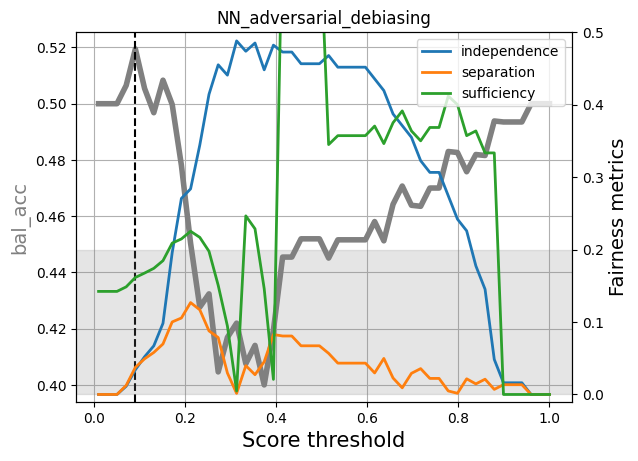

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [20]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

models[model_name].scores_train = models[model_name].predict(data_train_copy).scores
models[model_name].scores_val = models[model_name].predict(data_val_copy).scores
models[model_name].scores_test = models[model_name].predict(data_test_copy).scores

epoch 0; iter: 0; batch classifier loss: 0.707212
epoch 1; iter: 0; batch classifier loss: 0.690274
epoch 2; iter: 0; batch classifier loss: 0.683431
epoch 3; iter: 0; batch classifier loss: 0.675249
epoch 4; iter: 0; batch classifier loss: 0.683098
epoch 5; iter: 0; batch classifier loss: 0.657345
epoch 6; iter: 0; batch classifier loss: 0.639329
epoch 7; iter: 0; batch classifier loss: 0.666718
epoch 8; iter: 0; batch classifier loss: 0.660291
epoch 9; iter: 0; batch classifier loss: 0.650029
epoch 10; iter: 0; batch classifier loss: 0.643680
epoch 11; iter: 0; batch classifier loss: 0.628793
epoch 12; iter: 0; batch classifier loss: 0.609086
epoch 13; iter: 0; batch classifier loss: 0.600875
epoch 14; iter: 0; batch classifier loss: 0.632551
epoch 15; iter: 0; batch classifier loss: 0.652849
epoch 16; iter: 0; batch classifier loss: 0.620067
epoch 17; iter: 0; batch classifier loss: 0.612178
epoch 18; iter: 0; batch classifier loss: 0.627917
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5254
Balanced accuracy: 0.5747
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.2089
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0694
Sufficiency ( |ΔPPV| ) : 0.0879
CPU times: user 167 ms, sys: 18.7 ms, total: 185 ms
Wall time: 166 ms


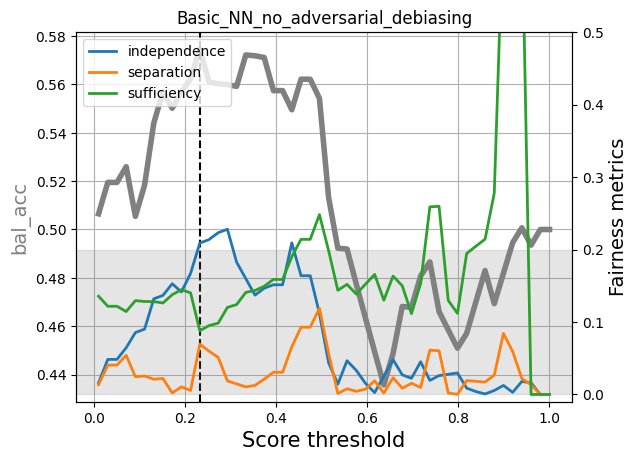

In [21]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Inprocesado

### Reponderación + Eliminador de prejuicios

In [22]:
# Nombre del modelo
model_name = 'reweighting_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + Eliminador de prejuicios

In [ ]:
# Nombre del modelo
model_name = 'disparate_impact_prejudice_remover'

# Hacemos una copia de los datasets (usando uno de lo métodos de pre-procesado vistos anteriormente)
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

In [ ]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + metafairness

In [23]:
%%time 
# Nombramos al modelo
model_name = 'reweighing_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:36: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:37: RuntimeWarning: invalid value encountered in divide
  prob_z_0 = (prob_m1_0 + prob_1_0) / total
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/aif360/algorithms/inprocessing/celisMeta/StatisticalRate.py:38: RuntimeWarning: invalid value encountered in divide
  prob_z_1 = (prob_m1_1 + prob_1_1) / total


TypeError: cannot unpack non-iterable NoneType object

In [24]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for reweighing_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Impacto dispar + metafairness

In [25]:
%%time 
# Nombramos al modelo
model_name = 'disparate_impact_meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

TypeError: cannot unpack non-iterable NoneType object

In [26]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for disparate_impact_meta_fairness_sr


AttributeError: 'MetaFairClassifier' object has no attribute 'model'

### Reponderación + prejuicios adversarios

In [27]:
%%time

# Nombramos al modelo
model_name = 'reweighing_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.682557; batch adversarial loss: 0.812126
epoch 1; iter: 0; batch classifier loss: 0.731113; batch adversarial loss: 0.871086
epoch 2; iter: 0; batch classifier loss: 0.722729; batch adversarial loss: 0.867104
epoch 3; iter: 0; batch classifier loss: 0.723143; batch adversarial loss: 0.846327
epoch 4; iter: 0; batch classifier loss: 0.696984; batch adversarial loss: 0.803001
epoch 5; iter: 0; batch classifier loss: 0.659646; batch adversarial loss: 0.800822
epoch 6; iter: 0; batch classifier loss: 0.703563; batch adversarial loss: 0.854183
epoch 7; iter: 0; batch classifier loss: 0.696488; batch adversarial loss: 0.885983
epoch 8; iter: 0; batch classifier loss: 0.657613; batch adversarial loss: 0.836639
epoch 9; iter: 0; batch classifier loss: 0.692013; batch adversarial loss: 0.865651
epoch 10; iter: 0; batch classifier loss: 0.649643; batch adversarial loss: 0.801761
epoch 11; iter: 0; batch classifier loss: 0.688126; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6363
AUC: 0.5469
Balanced accuracy: 0.5539
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.1990
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0735
Sufficiency ( |ΔPPV| ) : 0.2038
CPU times: user 286 ms, sys: 260 ms, total: 546 ms
Wall time: 189 ms


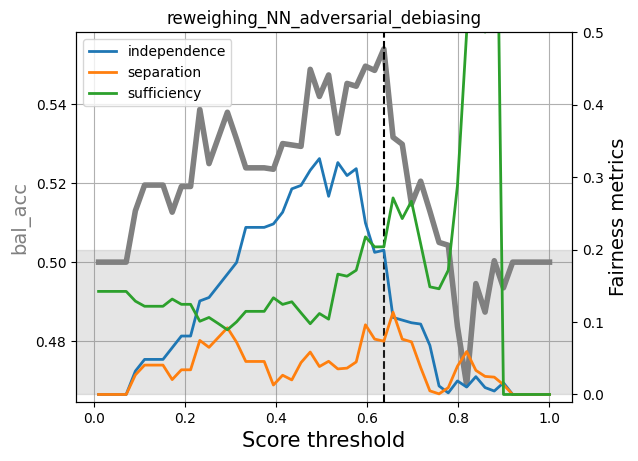

In [28]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Reponderación + red neuronal normal

In [29]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'reweighin_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.669185
epoch 1; iter: 0; batch classifier loss: 0.685185
epoch 2; iter: 0; batch classifier loss: 0.713551
epoch 3; iter: 0; batch classifier loss: 0.705042
epoch 4; iter: 0; batch classifier loss: 0.658470
epoch 5; iter: 0; batch classifier loss: 0.698709
epoch 6; iter: 0; batch classifier loss: 0.648928
epoch 7; iter: 0; batch classifier loss: 0.651959
epoch 8; iter: 0; batch classifier loss: 0.660762
epoch 9; iter: 0; batch classifier loss: 0.648533
epoch 10; iter: 0; batch classifier loss: 0.659171
epoch 11; iter: 0; batch classifier loss: 0.643117
epoch 12; iter: 0; batch classifier loss: 0.616343
epoch 13; iter: 0; batch classifier loss: 0.630626
epoch 14; iter: 0; batch classifier loss: 0.643440
epoch 15; iter: 0; batch classifier loss: 0.636680
epoch 16; iter: 0; batch classifier loss: 0.670020
epoch 17; iter: 0; batch classifier loss: 0.640681
epoch 18; iter: 0; batch classifier loss: 0.648264
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5287
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.1880
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0090
Sufficiency ( |ΔPPV| ) : 0.1277
CPU times: user 186 ms, sys: 15.9 ms, total: 202 ms
Wall time: 183 ms


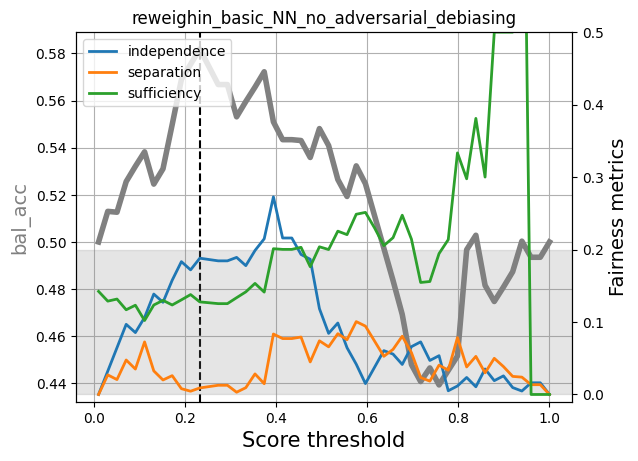

In [30]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + eliminación de prejuicios adversarios

In [31]:
%%time

# Nombramos al modelo
model_name = 'disparate_impact_NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.711929; batch adversarial loss: 0.607904
epoch 1; iter: 0; batch classifier loss: 0.691026; batch adversarial loss: 0.607913
epoch 2; iter: 0; batch classifier loss: 0.693545; batch adversarial loss: 0.613425
epoch 3; iter: 0; batch classifier loss: 0.686387; batch adversarial loss: 0.604071
epoch 4; iter: 0; batch classifier loss: 0.706123; batch adversarial loss: 0.619083
epoch 5; iter: 0; batch classifier loss: 0.703858; batch adversarial loss: 0.606642
epoch 6; iter: 0; batch classifier loss: 0.695546; batch adversarial loss: 0.626440
epoch 7; iter: 0; batch classifier loss: 0.677321; batch adversarial loss: 0.627601
epoch 8; iter: 0; batch classifier loss: 0.602926; batch adversarial loss: 0.635055
epoch 9; iter: 0; batch classifier loss: 0.663154; batch adversarial loss: 0.617048
epoch 10; iter: 0; batch classifier loss: 0.645984; batch adversarial loss: 0.628613
epoch 11; iter: 0; batch classifier loss: 0.647094; batch adversarial loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.4905
Balanced accuracy: 0.5264
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.0858
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0983
Sufficiency ( |ΔPPV| ) : 0.2090
CPU times: user 199 ms, sys: 13.2 ms, total: 212 ms
Wall time: 187 ms


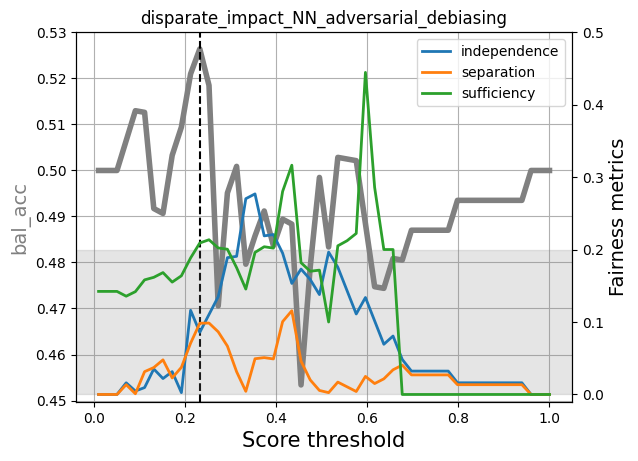

In [32]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Impacto dispar + red neuronal normal

In [33]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'disparate_impact_basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 0.720800
epoch 1; iter: 0; batch classifier loss: 0.669792
epoch 2; iter: 0; batch classifier loss: 0.697937
epoch 3; iter: 0; batch classifier loss: 0.690409
epoch 4; iter: 0; batch classifier loss: 0.665179
epoch 5; iter: 0; batch classifier loss: 0.661577
epoch 6; iter: 0; batch classifier loss: 0.666995
epoch 7; iter: 0; batch classifier loss: 0.669619
epoch 8; iter: 0; batch classifier loss: 0.638924
epoch 9; iter: 0; batch classifier loss: 0.640474
epoch 10; iter: 0; batch classifier loss: 0.634237
epoch 11; iter: 0; batch classifier loss: 0.637359
epoch 12; iter: 0; batch classifier loss: 0.675317
epoch 13; iter: 0; batch classifier loss: 0.636502
epoch 14; iter: 0; batch classifier loss: 0.617828
epoch 15; iter: 0; batch classifier loss: 0.644482
epoch 16; iter: 0; batch classifier loss: 0.589081
epoch 17; iter: 0; batch classifier loss: 0.587154
epoch 18; iter: 0; batch classifier loss: 0.635797
epoch 19; iter: 0; batch classifier loss:

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5019
Balanced accuracy: 0.5592
Accuracy: 0.5533
Independence ( |ΔP(Y_pred = 1)| ): 0.1551
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0115
Sufficiency ( |ΔPPV| ) : 0.1438
CPU times: user 185 ms, sys: 20.6 ms, total: 206 ms
Wall time: 185 ms


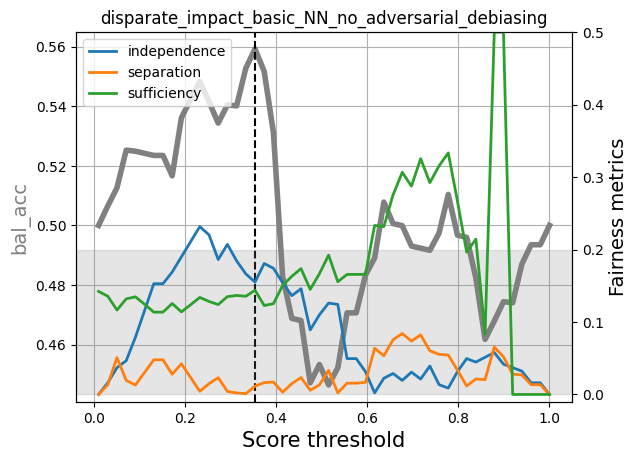

In [34]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Preprocesado + Postprocesado

### Entrenamiento de modelos con técnicas de preprocesado

#### Reponderación

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5058
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0319
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0862
Sufficiency ( |ΔPPV| ) : 0.1966


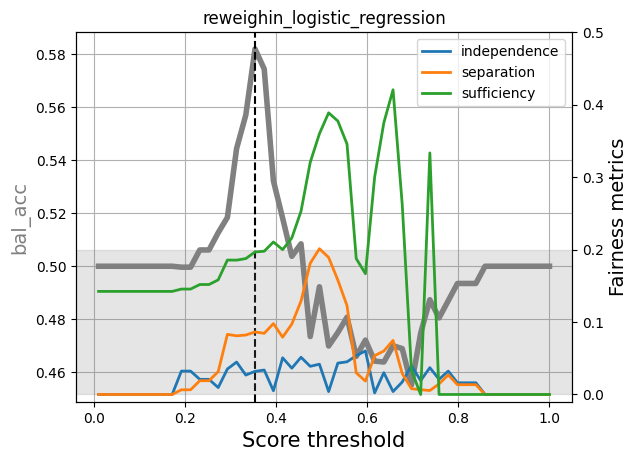

In [35]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Regresión logística
model_name = 'reweighin_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.0466
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0301
Sufficiency ( |ΔPPV| ) : 0.1261
CPU times: user 32.3 s, sys: 194 ms, total: 32.5 s
Wall time: 647 ms


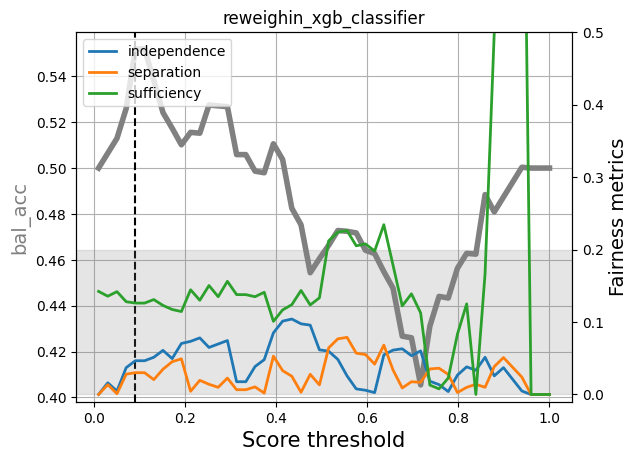

In [36]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_REW.copy(deepcopy=True), data_val_REW.copy(deepcopy=True), data_test_REW.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'reweighin_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Disparate impact

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4141
AUC: 0.5367
Balanced accuracy: 0.5650
Accuracy: 0.5600
Independence ( |ΔP(Y_pred = 1)| ): 0.2082
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1498
Sufficiency ( |ΔPPV| ) : 0.2462


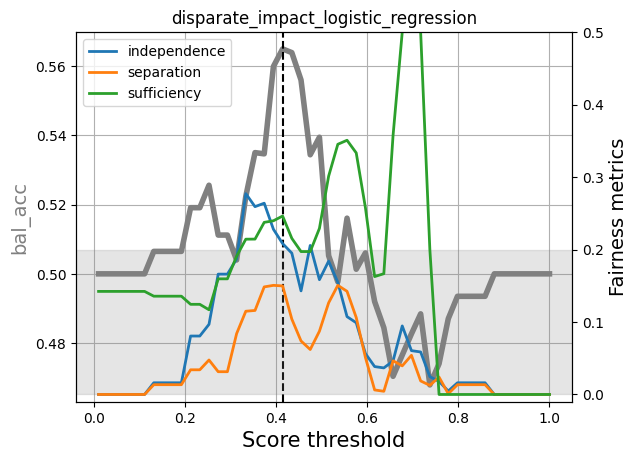

In [37]:
# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Regresión logística
model_name = 'disparate_impact_logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.0466
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0301
Sufficiency ( |ΔPPV| ) : 0.1261
CPU times: user 33.5 s, sys: 174 ms, total: 33.6 s
Wall time: 669 ms


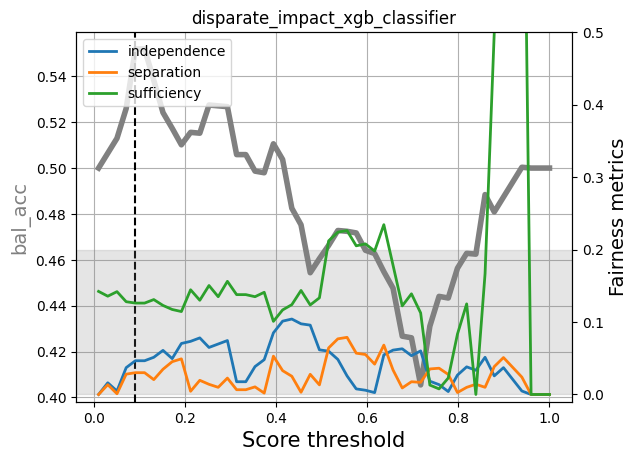

In [38]:
%%time 

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train_DIR.copy(deepcopy=True), data_val_DIR.copy(deepcopy=True), data_test_DIR.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Nombramos al modelo
model_name = 'disparate_impact_xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [39]:
#Anotamos los nombres de los modelos
model_names = ['reweighin_logistic_regression', 'reweighin_xgb_classifier', 'disparate_impact_logistic_regression', 'disparate_impact_xgb_classifier']

### Aplicación de técnicas de postprocesado 

#### Reponderación + Clasificación de rechazo de opción

In [40]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 11 s, sys: 3.47 s, total: 14.4 s
Wall time: 10.4 s


In [41]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

reweighin_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4654
AUC: 0.5058
Balanced accuracy: 0.4674
Accuracy: 0.4667
Independence ( |ΔP(Y_pred = 1)| ): 0.0311
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1025
Sufficiency ( |ΔPPV| ) : 0.2579


reweighin_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.5247
AUC: 0.5058
Balanced accuracy: 0.4829
Accuracy: 0.4867
Independence ( |ΔP(Y_pred = 1)| ): 0.0188
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1120
Sufficiency ( |ΔPPV| ) : 0.3227


reweighin_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.5742
AUC: 0.5058
Balanced accuracy: 0.4462
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0955
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0422
Sufficiency ( |ΔPPV| ) : 0.2009




In [42]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 11 s, sys: 180 ms, total: 11.2 s
Wall time: 9.67 s


In [43]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

reweighin_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3466
AUC: 0.4613
Balanced accuracy: 0.4403
Accuracy: 0.4400
Independence ( |ΔP(Y_pred = 1)| ): 0.3896
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2077
Sufficiency ( |ΔPPV| ) : 0.0173


reweighin_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027


reweighin_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027




#### Impacto dispar + Rechazo de opción

In [44]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.1 s, sys: 3.44 s, total: 13.6 s
Wall time: 9.32 s


In [45]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

disparate_impact_logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.4357
AUC: 0.5367
Balanced accuracy: 0.4663
Accuracy: 0.4667
Independence ( |ΔP(Y_pred = 1)| ): 0.0476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0926
Sufficiency ( |ΔPPV| ) : 0.2692


disparate_impact_logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.4258
AUC: 0.5367
Balanced accuracy: 0.4803
Accuracy: 0.4800
Independence ( |ΔP(Y_pred = 1)| ): 0.0806
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1078
Sufficiency ( |ΔPPV| ) : 0.2849


disparate_impact_logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.4456
AUC: 0.5367
Balanced accuracy: 0.4663
Accuracy: 0.4667
Independence ( |ΔP(Y_pred = 1)| ): 0.0903
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0577
Sufficiency ( |ΔPPV| ) : 0.2418




In [46]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 10.8 s, sys: 99.7 ms, total: 10.9 s
Wall time: 9.44 s


In [47]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

disparate_impact_xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3466
AUC: 0.4613
Balanced accuracy: 0.4403
Accuracy: 0.4400
Independence ( |ΔP(Y_pred = 1)| ): 0.3896
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2077
Sufficiency ( |ΔPPV| ) : 0.0173


disparate_impact_xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027


disparate_impact_xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027




#### Reponderación y impacto dispar + Escalado de Platt por grupos

In [48]:
%%time
fairness_method = '_platt_scaling'
model_names = model_names
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name], class_thresh = model_thresh)
    data_val_preds_m = utils.update_dataset_from_model2(data_val, data_val2_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2_m = data_val_preds_m.copy(deepcopy = True)
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        data_val_preds2_m.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores_mult(
            dataset_true = data_val_copy,
            dataset2 =data_val2_copy,
            dataset_preds = data_val_preds2_m,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for reweighin_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.5196
AUC: 0.5435
Balanced accuracy: 0.5712
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.4216
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0697
Sufficiency ( |ΔPPV| ) : 0.0541

Validation set results for reweighin_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.4877
AUC: 0.6186
Balanced accuracy: 0.6296
Accuracy: 0.6267
Independence ( |ΔP(Y_pred = 1)| ): 0.4567
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0873
Sufficiency ( |ΔPPV| ) : 0.0333

Validation set results for disparate_impact_logistic_regression
Threshold corresponding to *best balanced accuracy*: 0.3549
AUC: 0.5465
Balanced accuracy: 0.5549
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.4677
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0568
Sufficiency ( |ΔPPV| ) : 0.0909

Validation set results for disparate_impact_xgb_classifier
Threshold corresponding to *best balanced accuracy*: 0.4877
AUC: 0.6186
Balanced

In [49]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    data_test_preds_m = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    data_test_preds2_m = data_test_preds_m.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)

    data_test_preds2_m = data_test2_copy.copy(deepcopy = True)
    data_test_preds2_m.scores = data_test_preds2.scores
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores_mult(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2_m,
                                                                                             dataset2=data_test2_copy,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Reponderación + Procesador de probabilidades igualadas

##### Usando labels

In [50]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [51]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [52]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [53]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [54]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 226 ms, sys: 1.02 s, total: 1.24 s
Wall time: 39.9 ms


In [55]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for reweighin_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5058
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0094
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0578
Sufficiency ( |ΔPPV| ) : 0.1490


Results for reweighin_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5058
Balanced accuracy: 0.5751
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.0251
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0078
Sufficiency ( |ΔPPV| ) : 0.1744


Results for reweighin_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5058
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.0094
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0578
Sufficiency ( |ΔPPV| ) : 0.1490




In [56]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'reweighin_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 4.06 s, sys: 119 ms, total: 4.18 s
Wall time: 80 ms


In [57]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for reweighin_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172


Results for reweighin_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172


Results for reweighin_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172




#### Impacto dispar + Procesador de probabilidades igualadas

##### Usando labels

In [58]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [59]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [60]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [61]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2=data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

##### Usando scores

In [62]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 163 ms, sys: 1.04 s, total: 1.21 s
Wall time: 39.1 ms


In [63]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for disparate_impact_logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3939
AUC: 0.5367
Balanced accuracy: 0.5982
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.8430
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0644
Sufficiency ( |ΔPPV| ) : 0.5588


Results for disparate_impact_logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.4747
AUC: 0.5367
Balanced accuracy: 0.5423
Accuracy: 0.5333
Independence ( |ΔP(Y_pred = 1)| ): 0.8621
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0289
Sufficiency ( |ΔPPV| ) : 0.2707


Results for disparate_impact_logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3939
AUC: 0.5367
Balanced accuracy: 0.5982
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.8430
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0644
Sufficiency ( |ΔPPV| ) : 0.5588




In [64]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'disparate_impact_xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 4.1 s, sys: 132 ms, total: 4.23 s
Wall time: 80.8 ms


In [65]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for disparate_impact_xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172


Results for disparate_impact_xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172


Results for disparate_impact_xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4613
Balanced accuracy: 0.5519
Accuracy: 0.5400
Independence ( |ΔP(Y_pred = 1)| ): 0.1476
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1057
Sufficiency ( |ΔPPV| ) : 0.1172




## Inprocesado + Postprocesado

In [66]:
#Anotamos los nombres de los modelos que vamos a usar
model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']

### Eliminador de prejuicios + rechazo de opción

In [67]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

In [68]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

KeyError: 'prejudice_remover_reject_option_spd'

### Metafairness + rechazo de opción

In [69]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.34 s, sys: 135 ms, total: 9.47 s
Wall time: 9.47 s


In [70]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_sr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3466
AUC: 0.4613
Balanced accuracy: 0.4403
Accuracy: 0.4400
Independence ( |ΔP(Y_pred = 1)| ): 0.3896
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2077
Sufficiency ( |ΔPPV| ) : 0.0173


meta_fairness_sr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027


meta_fairness_sr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.5271
Accuracy: 0.5200
Independence ( |ΔP(Y_pred = 1)| ): 0.1810
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0406
Sufficiency ( |ΔPPV| ) : 0.2027




### Prejuicios adversarios + rechazo de opción

In [71]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.5 s, sys: 115 ms, total: 9.62 s
Wall time: 9.62 s


In [72]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2=data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset2=data_test2_copy,
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

meta_fairness_fdr_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3466
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552


meta_fairness_fdr_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552


meta_fairness_fdr_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552




### Red neuronal normal + rechazo de opción

In [73]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
#data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
#data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
#data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.66 s, sys: 82.5 ms, total: 9.74 s
Wall time: 9.74 s


In [74]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2=data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

NN_adversarial_debiasing_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.3466
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552


NN_adversarial_debiasing_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552


NN_adversarial_debiasing_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.2476
AUC: 0.4613
Balanced accuracy: 0.4537
Accuracy: 0.4533
Independence ( |ΔP(Y_pred = 1)| ): 0.0777
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0068
Sufficiency ( |ΔPPV| ) : 0.1552




### Inprocesado + Escalado Platt por grupos

In [75]:
%%time
fairness_method = '_platt_scaling'

model_names = ['NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['meta_fairness_fdr', 'meta_fairness_sr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
#model_names = ['prejudice_remover', 'meta_fairness_sr', 'meta_fairness_fdr', 'NN_adversarial_debiasing', 'Basic_NN_no_adversarial_debiasing']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                            'unpriv': [data_val_preds_unpriv, unpriv_indices]}
    
    for group, data_group_list in sensitive_groups_data.items():
    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)
    
        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()
    
        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                      data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
            
        # Evaluamos a los modelos para el rango de umbrales
        thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                         np.max(data_val_preds2.scores.ravel()),
                                         50)
        data_val_preds2_m = data_val2_copy.copy(deepcopy = True)
        data_val_preds2_m.scores = data_val_preds2.scores
        metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores_mult(
                dataset_true = data_val_copy,
                dataset2=data_val2_copy,
                dataset_preds = data_val_preds2_m,
                thresh_arr = thresh_sweep_platt
            )
    
        # Evaluamos las métricas para el mejor umbral y las guardamos
        metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )
    
        # Graficamos el comportamiento del modelo para el rango de umbrales 
        print('\nValidation set results for {}'.format(model_name))
        utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
        # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
        # plt.title( model_name+fairness_method )
        
        f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
        a.set_title(model_name+fairness_method )
        f


Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5134
AUC: 0.4709
Balanced accuracy: 0.5228
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.0026
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0603
Sufficiency ( |ΔPPV| ) : 0.1771

Validation set results for NN_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5071
AUC: 0.5807
Balanced accuracy: 0.6000
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.4479
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0452
Sufficiency ( |ΔPPV| ) : 0.0732

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.2466
AUC: 0.5616
Balanced accuracy: 0.5574
Accuracy: 0.5467
Independence ( |ΔP(Y_pred = 1)| ): 0.2419
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1022
Sufficiency ( |ΔPPV| ) : 0.0774

Validation set results for Basic_NN_no_adversarial_debiasing
Threshold corresponding to *best balanced accuracy*: 0.5168
AUC: 0.5734
Balanced accur

In [76]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, model_thresh)
    
    # 1. dividir el validation data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    data_test_preds2_m = data_test2_copy.copy(deepcopy=True)
    data_test_preds2_m.scores = data_test2_copy.scores
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores_mult(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2,
                                                                                             dataset2=data_test2_copy,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

#### Eliminador de prejuicios + Procesador de probabilidades igualadas

##### Usando labels

In [77]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [78]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [79]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[0]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 15 ms, sys: 2.99 ms, total: 18 ms
Wall time: 17.1 ms


In [80]:
display(Markdown("**Validation set results for prejudice remover**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for prejudice remover**

Results for NN_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4215
Balanced accuracy: 0.5000
Accuracy: 0.4867
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1758


Results for NN_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.0908
AUC: 0.4215
Balanced accuracy: 0.5195
Accuracy: 0.5067
Independence ( |ΔP(Y_pred = 1)| ): 0.0248
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0259
Sufficiency ( |ΔPPV| ) : 0.1891


Results for NN_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4215
Balanced accuracy: 0.5000
Accuracy: 0.4867
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.1758




#### Metafairness + Procesador de probabilidades igualadas

##### Usando labels

In [81]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

2024-06-19 10:19:06.509046: W tensorflow/c/c_api.cc:305] Operation '{name:'biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign' id:264 op device:{requested: '', assigned: ''} def:{{{node biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](biased_classifier/biased_classifier/classifier_model/b2/Adam_1, biased_classifier/biased_classifier/classifier_model/b2/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [82]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [83]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[1]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 37.1 ms, sys: 5.05 ms, total: 42.1 ms
Wall time: 30.7 ms


In [84]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5254
Balanced accuracy: 0.5794
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.2169
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1468
Sufficiency ( |ΔPPV| ) : 0.0484


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5254
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.4181
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1286
Sufficiency ( |ΔPPV| ) : 0.0413


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5254
Balanced accuracy: 0.5715
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3728
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0487
Sufficiency ( |ΔPPV| ) : 0.0949




##### Usando labels

In [85]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [86]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [87]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[2]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [88]:
display(Markdown("**Validation set results for metafairness**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for metafairness**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5254
Balanced accuracy: 0.5794
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.2169
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1468
Sufficiency ( |ΔPPV| ) : 0.0484


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5254
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.4181
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1286
Sufficiency ( |ΔPPV| ) : 0.0413


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5254
Balanced accuracy: 0.5715
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3728
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0487
Sufficiency ( |ΔPPV| ) : 0.0949




#### Prejuicios adversarios + Procesador de probabilidades igualadas

##### Usando labels

In [89]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [90]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [91]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[3]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_NN_ADV = metrics_best_thresh_validate['NN_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [92]:
display(Markdown("**Validation set results for adversarial debiasing**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for adversarial debiasing**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5254
Balanced accuracy: 0.5794
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.2169
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1468
Sufficiency ( |ΔPPV| ) : 0.0484


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5254
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.4181
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1286
Sufficiency ( |ΔPPV| ) : 0.0413


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5254
Balanced accuracy: 0.5715
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3728
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0487
Sufficiency ( |ΔPPV| ) : 0.0949




#### Red neuronal normal + Procesador de probabilidades igualadas

##### Usando labels

In [93]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [94]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

#### Usando scores

In [95]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = model_names[4]

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

thresh_no_NN_ADV = metrics_best_thresh_validate['Basic_NN_no_adversarial_debiasing']['best_threshold']

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_scores(data_train_copy, models[model_name].scores_train, thresh_no_NN_ADV)
data_val_preds = utils.update_dataset_from_scores(data_val_copy, models[model_name].scores_val, thresh_no_NN_ADV)
data_test_preds = utils.update_dataset_from_scores(data_test_copy, models[model_name].scores_test, thresh_no_NN_ADV)


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

IndexError: list index out of range

In [96]:
display(Markdown("**Validation set results for basic NN**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for basic NN**

Results for Basic_NN_no_adversarial_debiasing_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.3333
AUC: 0.5254
Balanced accuracy: 0.5794
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.2169
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1468
Sufficiency ( |ΔPPV| ) : 0.0484


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.2322
AUC: 0.5254
Balanced accuracy: 0.5819
Accuracy: 0.5733
Independence ( |ΔP(Y_pred = 1)| ): 0.4181
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1286
Sufficiency ( |ΔPPV| ) : 0.0413


Results for Basic_NN_no_adversarial_debiasing_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.3535
AUC: 0.5254
Balanced accuracy: 0.5715
Accuracy: 0.5667
Independence ( |ΔP(Y_pred = 1)| ): 0.3728
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0487
Sufficiency ( |ΔPPV| ) : 0.0949




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [97]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.414082,0.565024,0.560000,0.208211,0.149797,0.246218,0.536737
xgb_classifier,0.090816,0.551948,0.540000,0.046554,0.030068,0.126109,0.461306
NN_adversarial_debiasing,0.090816,0.519481,0.506667,0.034091,0.037500,0.161480,0.421455
Basic_NN_no_adversarial_debiasing,0.232245,0.574720,0.566667,0.208944,0.069369,0.087912,0.525351
reweighing_NN_adversarial_debiasing,0.636327,0.553905,0.553333,0.199047,0.073536,0.203774,0.546878
reweighin_basic_NN_no_adversarial_debiasing,0.232245,0.581925,0.573333,0.188050,0.009009,0.127733,0.528732
disparate_impact_NN_adversarial_debiasing,0.232245,0.526419,0.520000,0.085777,0.098322,0.209019,0.490482
disparate_impact_basic_NN_no_adversarial_debiasing,0.353469,0.559242,0.553333,0.155059,0.011464,0.143813,0.501868
reweighin_logistic_regression,0.353469,0.581925,0.573333,0.031891,0.086239,0.196641,0.505782
reweighin_xgb_classifier,0.090816,0.551948,0.540000,0.046554,0.030068,0.126109,0.461306


### Resultados en test

In [98]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.414082,0.526667,0.526667,0.202455,0.027922,0.109971,0.537600
xgb_classifier,0.090816,0.500000,0.500000,0.054795,0.005303,0.096179,0.486756
NN_adversarial_debiasing,0.090816,0.500000,0.500000,0.025974,0.002381,0.094612,0.430933
Basic_NN_no_adversarial_debiasing,0.232245,0.466667,0.466667,0.102295,0.020292,0.108359,0.501689
reweighing_NN_adversarial_debiasing,0.636327,0.506667,0.506667,0.283046,0.015801,0.078788,0.511289
reweighin_basic_NN_no_adversarial_debiasing,0.232245,0.513333,0.513333,0.061911,0.002814,0.094612,0.488889
disparate_impact_NN_adversarial_debiasing,0.232245,0.520000,0.520000,0.025440,0.063745,0.137374,0.474667
disparate_impact_basic_NN_no_adversarial_debiasing,0.353469,0.460000,0.460000,0.125245,0.041234,0.131924,0.465600
reweighin_logistic_regression,0.353469,0.500000,0.500000,0.008539,0.023647,0.079445,0.523556
reweighin_xgb_classifier,0.090816,0.500000,0.500000,0.054795,0.005303,0.096179,0.486756


In [99]:
algorithm_performance_summary.to_csv('SIMULATION_MULTALG_MULTSENS_high', index = True, sep=',', encoding='utf-8')